## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images


In [12]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import os
%matplotlib inline

import pickle

def calc_mtx_dst_and_save(root_dir,img_size):

    if not os.path.isdir(root_dir):
        print("The folder ",dir,  "doesn't exist")
        return 
    
    full_path = os.path.join(root_dir,'calibration*.jpg') 

    images = glob.glob(full_path)

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = mpimg.imread(fname)
        assert((img.shape[0]== img_size[1]) and (img.shape[1] ==img_size[0]))
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

              
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    
    full_pickle_path = os.path.join(root_dir,'camera_cal_pickle.p')           


    pickle.dump( dist_pickle, open(full_pickle_path, "wb" ) )
    print("dump finished!")
              
def get_mtx_dst(root_dir):
    
    full_pickle_path = os.path.join(root_dir,'camera_cal_pickle.p')           
    dist_pickle = {}
    dist_pickle = pickle.load(open(full_pickle_path,mode= "rb" ) )
    return dist_pickle["mtx"],dist_pickle["dist"]



## Secondly  Apply a distortion correction to raw images.


In [13]:
calc_mtx_dst_and_save("camera_cal",(1280,720))
mtx,dist = get_mtx_dst("camera_cal")

dump finished!


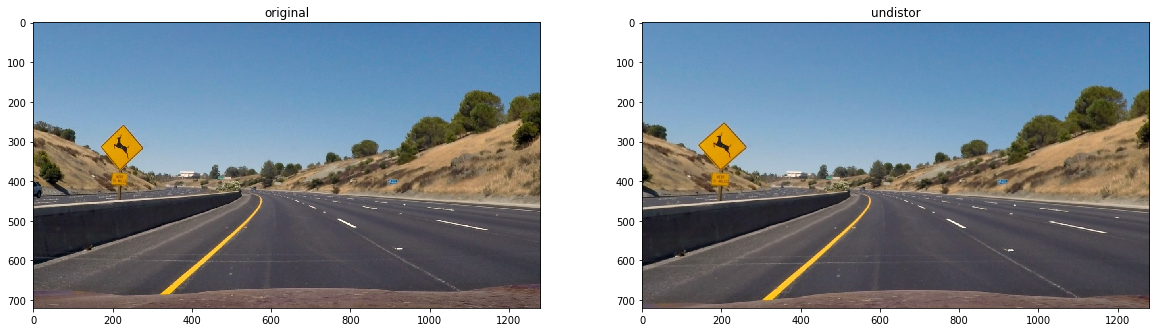

In [171]:
import matplotlib.image as mpimg
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline


def plot_images(images,titles,cmaps):
    
    assert(len(images) > 1)    
    assert(len(images) == len(titles))    
    assert(len(images) == len(cmaps))
    
    size = len(images) 
    f, ax = plt.subplots(1, size, figsize=(20,10))
    
    for i,image,title,cmap in zip(range(size),images,titles,cmaps):
        ax[i].imshow(image,cmap=cmap)
        ax[i].set_title(title) 

def get_perspective_transform():
    
    img = mpimg.imread("test_images/straight_lines1.jpg")
    src = np.float32([[203,700],[1076,720],[557,474],[723,474]])
    img_size = (img.shape[1], img.shape[0])              
    original_X = 320
    original_Y = 360
    extend_X = 640
    extend_Y = 360
    dst = np.float32([[original_X, original_Y+extend_Y],[original_X +extend_X, original_Y+extend_Y], 
                                     [original_X, original_Y], 
                                     [original_X + extend_X, original_Y]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    return M


M = get_perspective_transform()

def un_distor_demo():

    images = []
    titles = []
    cmaps  = []  
    
    img = mpimg.imread("test_images/test2.jpg")
    undistor_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    images.append(img)
    images.append(undistor_img)

    titles.append("original")
    titles.append("undistor")
    
    cmaps.append("viridis")
    cmaps.append("viridis")
    
    plot_images(images,titles,cmaps)

un_distor_demo()

In [163]:
def abs_sobel_thresh(img, orient='x', thresh=(20,100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
#    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(170, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1

    return binary_output

def hls_sobel_thresh_select(image):
    
    ksize = 3
    hls_binary = hls_select(image, thresh=(20, 255))
    gradx = abs_sobel_thresh(image, orient='x',  thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y',  thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(50, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.1))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined


import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image

def fine_lane(binary_warped):

    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    

    ploty = np.linspace(0, 719, num=720)
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])    
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
#     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#     plt.figure()
#     plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
#     plt.title(str(left_curverad) + " " + str(right_curverad))
    

    
    return left_fit,right_fit,left_curverad,right_curverad


def plot_lane(img,left_fit,right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img = np.dstack((img, img, img))*255

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.figure()
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)



127808.887619 6184.94706775
4072.86750717 11509.8181348
1295.76717476 1119.80705408
1365.65735009 1064.03493967
1423.88212841 1322.89473201
5622.62566849 1549.78085262
839.296706306 839.805157704
2967.77067594 2107.11892402


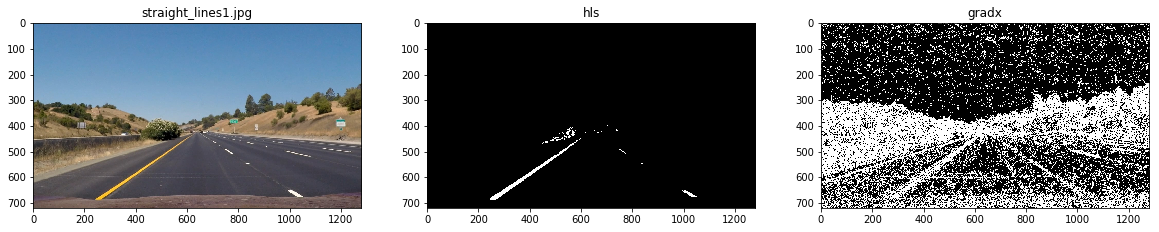

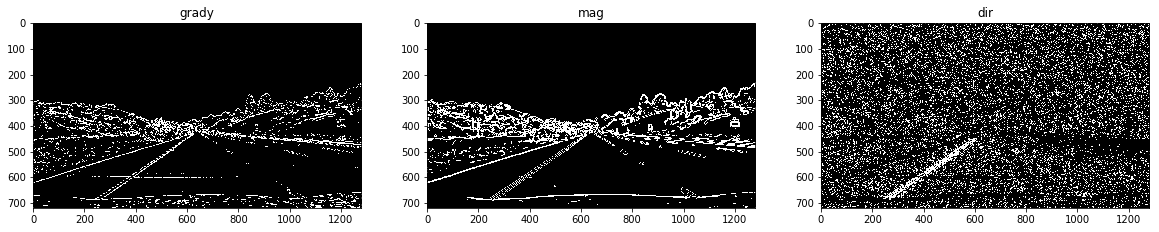

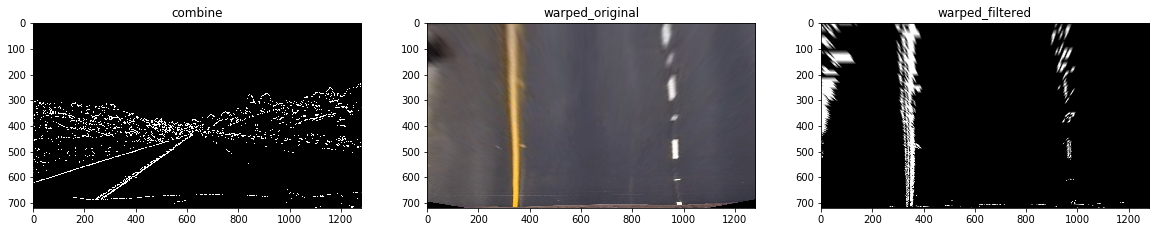

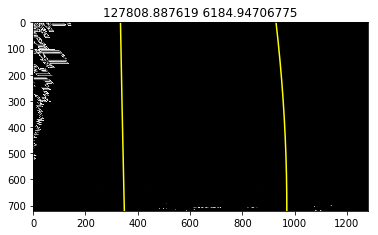

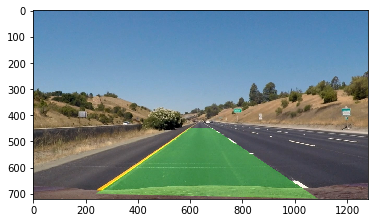

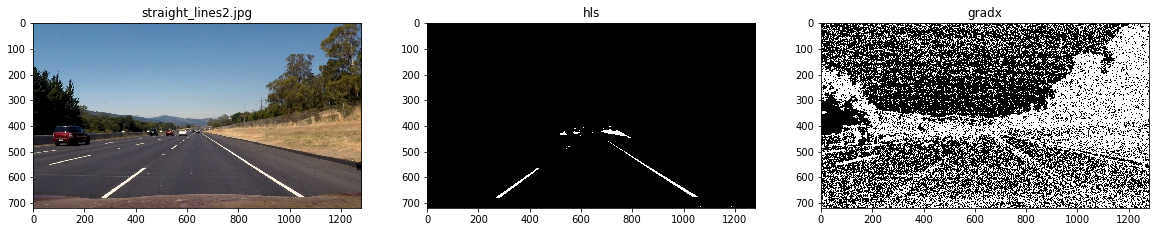

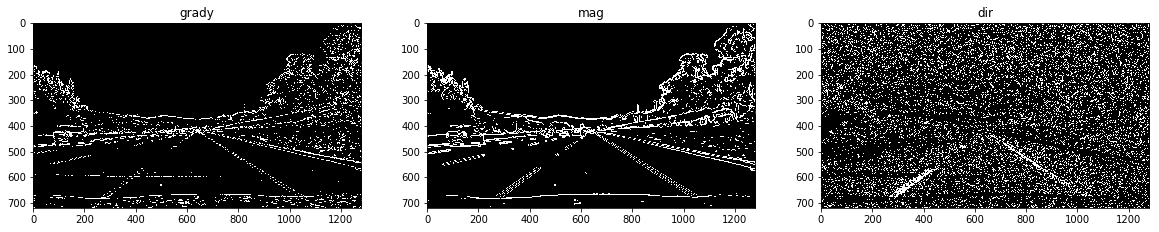

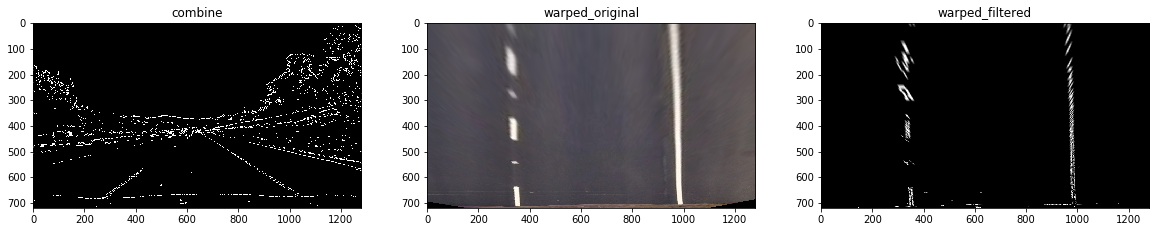

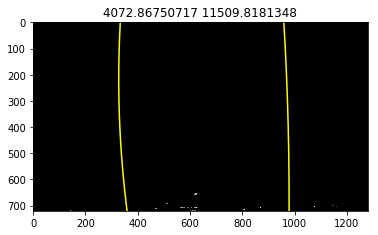

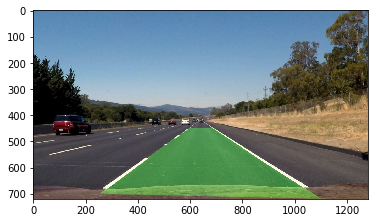

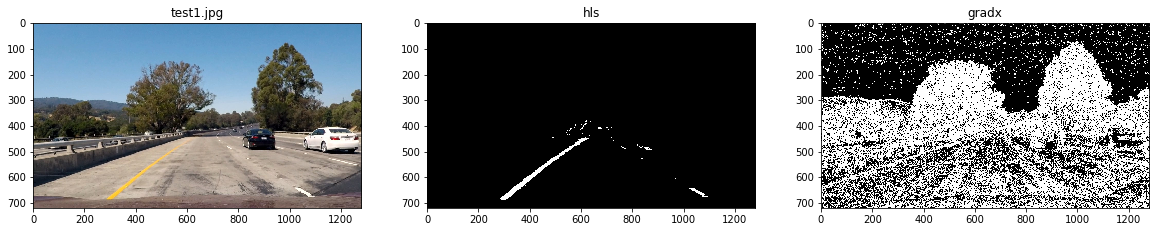

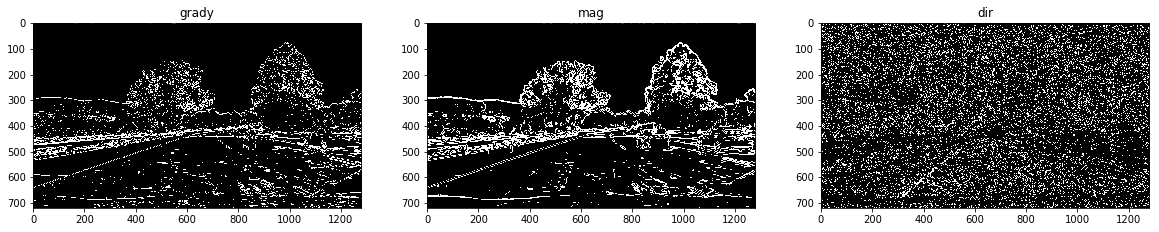

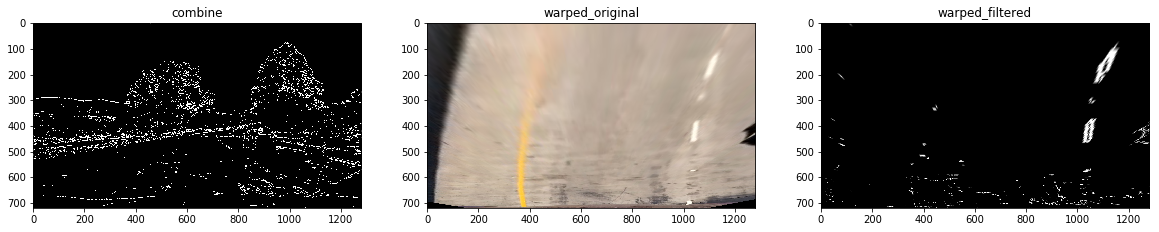

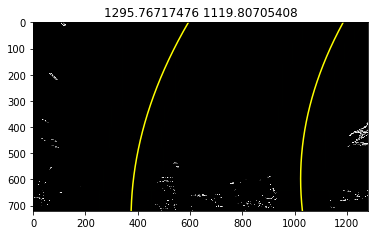

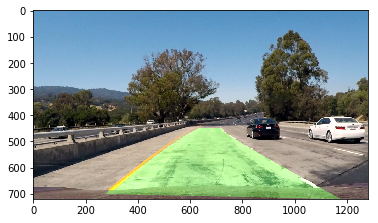

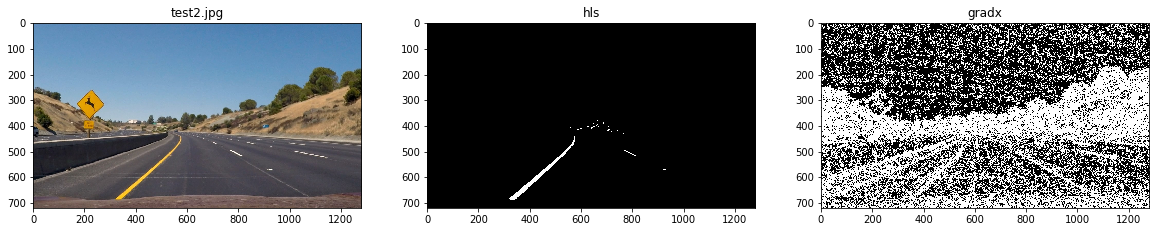

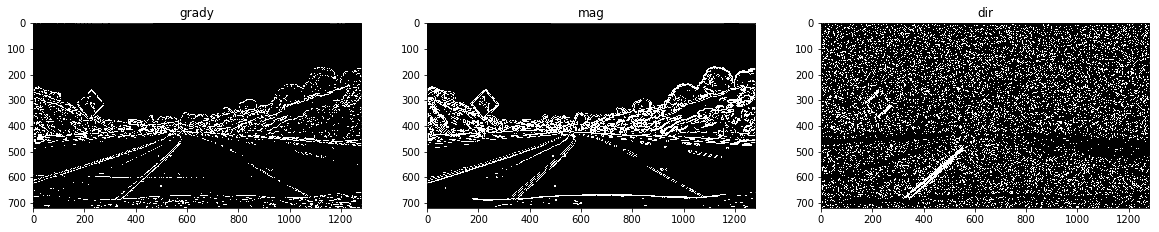

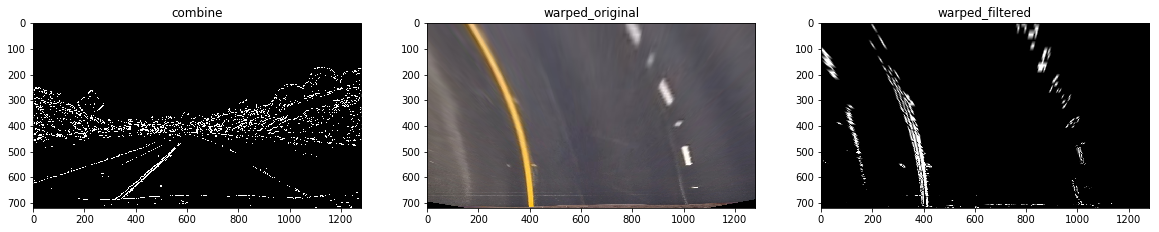

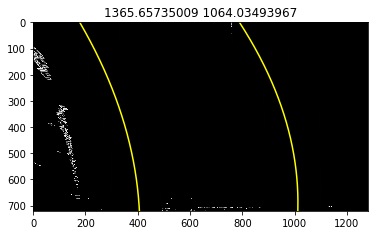

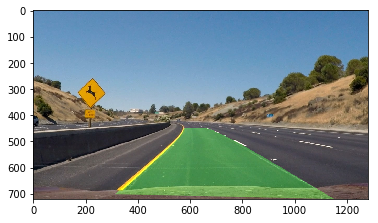

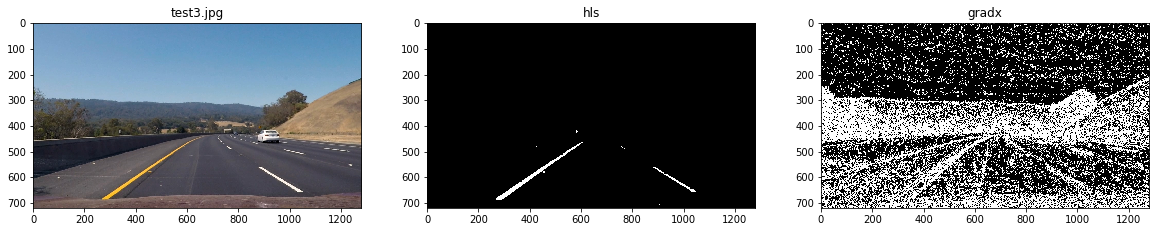

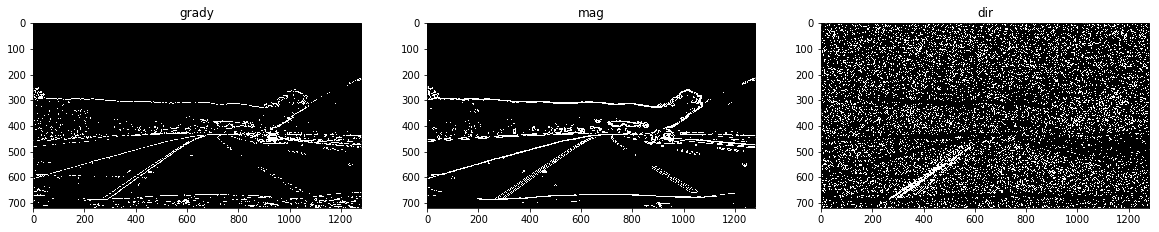

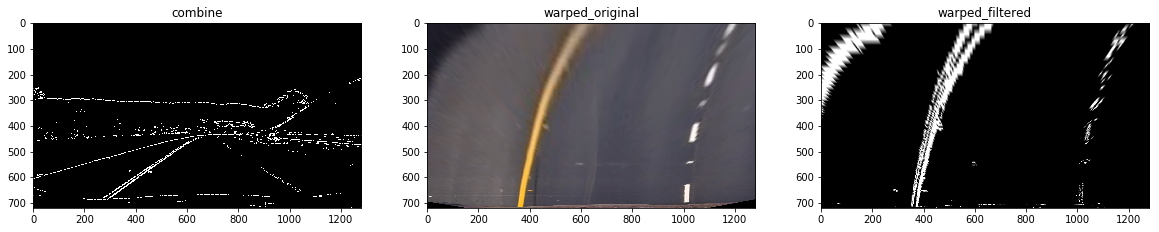

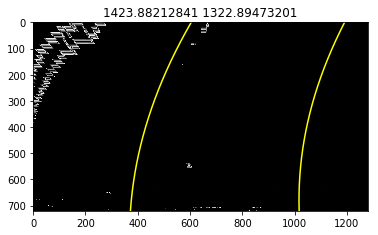

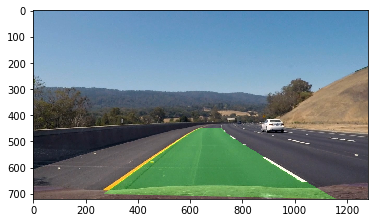

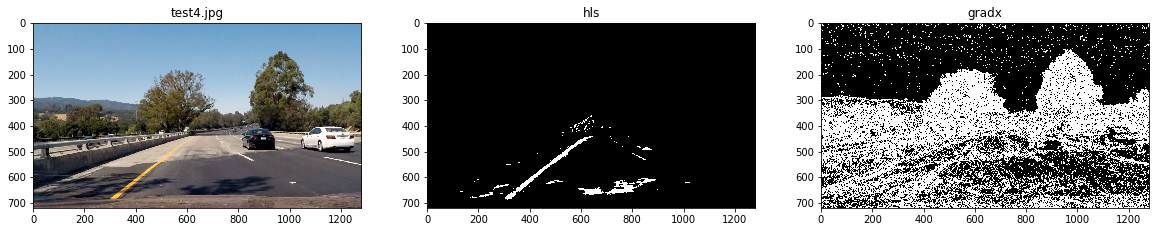

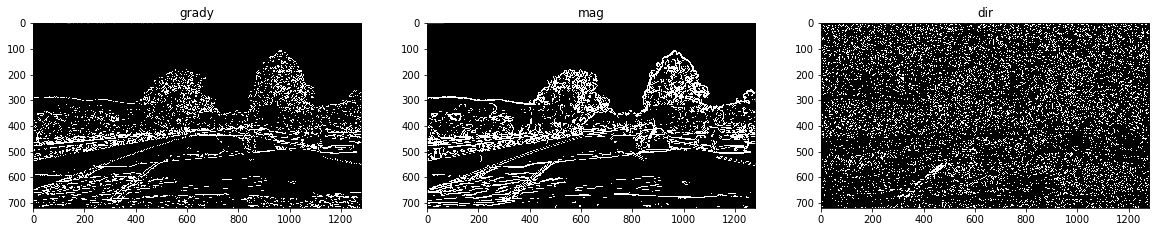

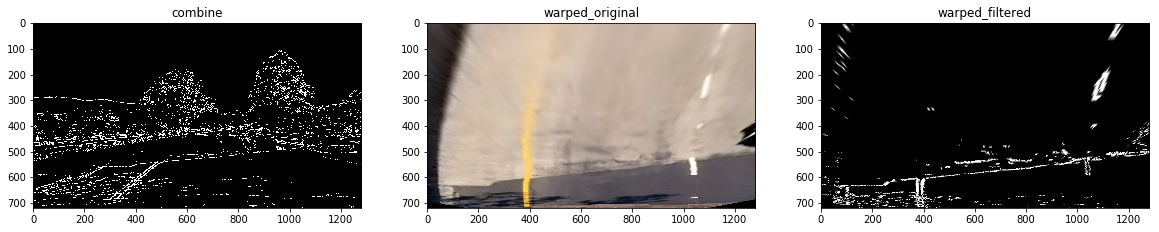

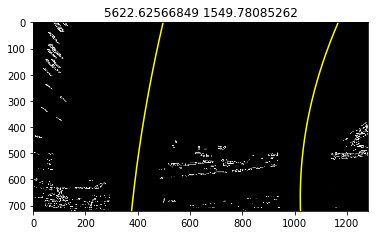

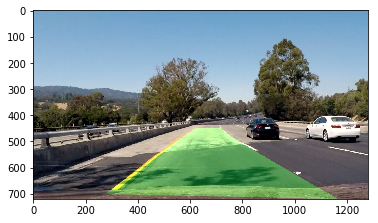

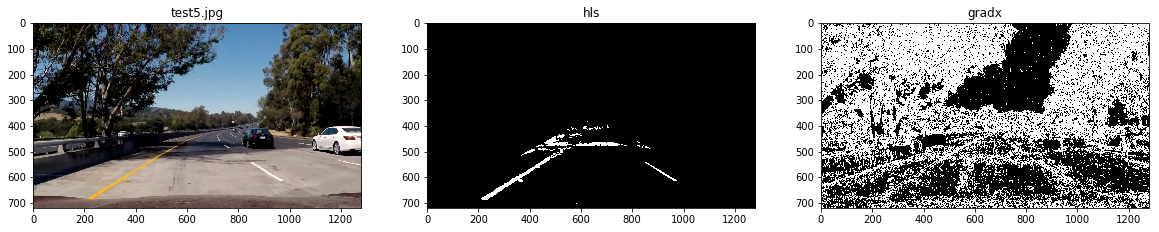

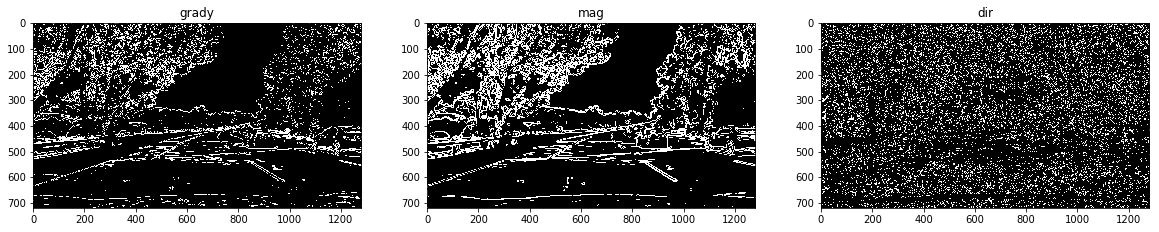

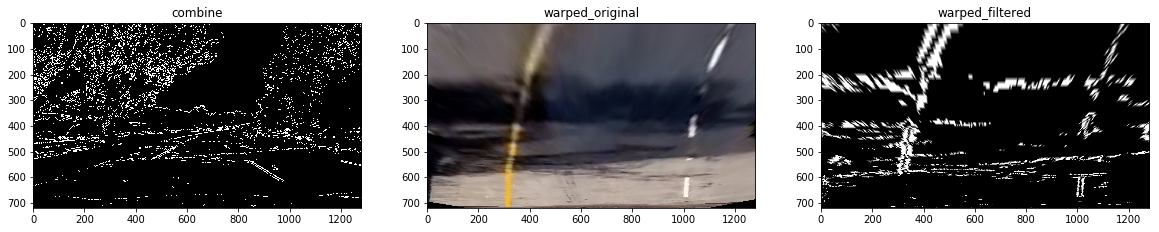

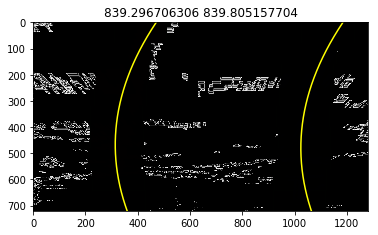

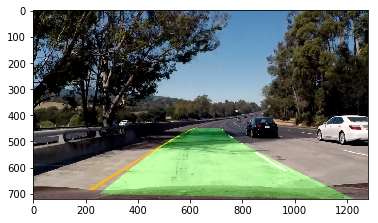

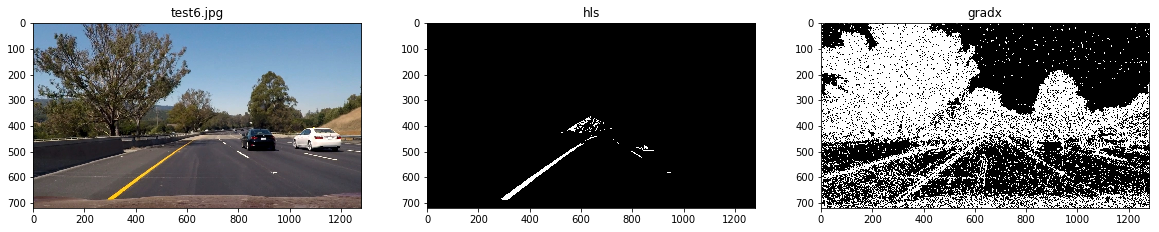

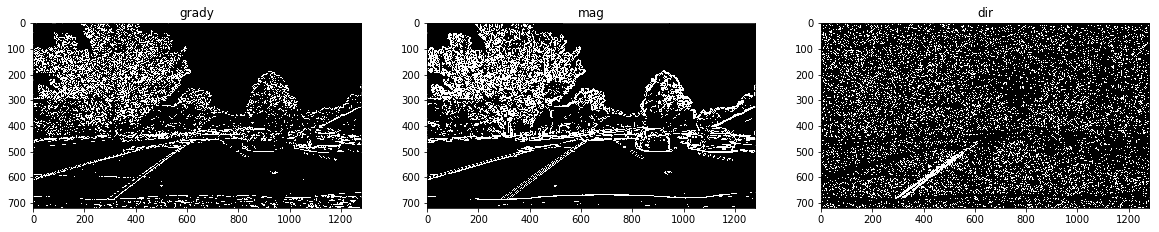

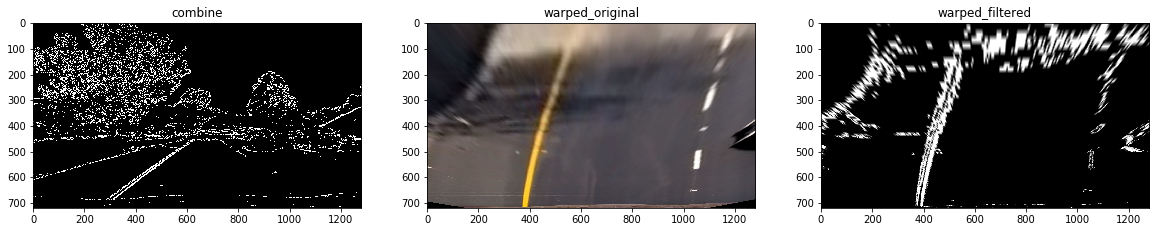

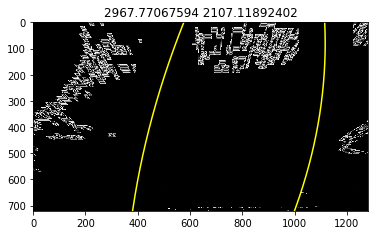

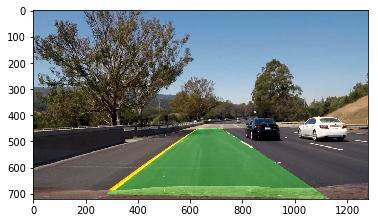

In [161]:


def draw_result_back(color_image,binary_warped,left_fit,right_fit):
# Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    from numpy.linalg import inv
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inv(M), (color_image.shape[1], color_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(color_image, 1, newwarp, 0.3, 0)
    return result

   

images = []
titles = []
cmaps  = []  



def select_region_of_interest(img,vertices):

    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



def process_image(img):
    
    
    img_size = (img.shape[1], img.shape[0])    
    undistor_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    image = undistor_img
    hls_binary = hls_select(image, thresh=(90, 255))
    hls_binary=select_region_of_interest(hls_binary,vertices)
                     
    gradx = abs_sobel_thresh(image, orient='x',  thresh=(2, 100))
    grady = abs_sobel_thresh(image, orient='y',  thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=15, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.0))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1) & (hls_binary ==1 ) | 
              (mag_binary == 1) & (dir_binary == 1) & (hls_binary ==1))  | 
             (gradx == 1) & (grady == 1) & (mag_binary == 1)
            ] = 1    
    
    warped = cv2.warpPerspective(combined, M, img_size)    
    left_fit,right_fit,left_curverad,right_curverad = fine_lane(np.array(warped))
    
    final_result= draw_result_back(undistor_img,warped,left_fit,right_fit)
    return final_result
    

for name in os.listdir("test_images"):
    images.clear()
    titles.clear()
    cmaps.clear()
    full_path = os.path.join("test_images",name)
    img = mpimg.imread(full_path)
    
    image = img
    hls_binary = hls_select(image, thresh=(90, 255))
    hls_binary=select_region_of_interest(hls_binary,vertices)

                     
    gradx = abs_sobel_thresh(image, orient='x',  thresh=(2, 100))
    grady = abs_sobel_thresh(image, orient='y',  thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=15, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.0))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1) & (hls_binary ==1 ) | 
              (mag_binary == 1) & (dir_binary == 1) & (hls_binary ==1))  | 
             (gradx == 1) & (grady == 1) & (mag_binary == 1)
            ] = 1    
    

    
    images.append(img)
    titles.append(name)
    cmaps.append("viridis")
    
    images.append(hls_binary)
    titles.append("hls")
    cmaps.append("gray")
    
    images.append(gradx)
    titles.append("gradx")
    cmaps.append("gray")    
    
    plot_images(images,titles,cmaps)
    
    images.clear()
    titles.clear()
    cmaps.clear()
    
    images.append(grady)
    titles.append("grady")
    cmaps.append("gray")
    
    images.append(mag_binary)
    titles.append("mag")
    cmaps.append("gray")
    
    images.append(dir_binary)
    titles.append("dir")
    cmaps.append("gray")    
    
    plot_images(images,titles,cmaps)
    
    images.clear()
    titles.clear()
    cmaps.clear()
    
    
    images.append(combined)
    titles.append("combine")
    cmaps.append("gray") 
    
    img_size = (img.shape[1], img.shape[0])    
    M = get_perspective_transform()

    warped = cv2.warpPerspective(img, M, img_size)    
    images.append(warped)
    titles.append("warped_original")
    cmaps.append("viridis") 

    warped = cv2.warpPerspective(combined, M, img_size)    
    images.append(warped)
    titles.append("warped_filtered")
    cmaps.append("gray") 
    plot_images(images,titles,cmaps)

    left_fit,right_fit,left_curverad,right_curverad = fine_lane(np.array(warped))
    
    final_result= draw_result_back(img,warped,left_fit,right_fit)
    plt.figure()
    plt.imshow(final_result)

    
   # plot_lane(warped,left_fit,right_fit)
    #plot_images(warped,titles,cmaps)


    

In [162]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

        
        
        


In [158]:
import imageio
imageio.plugins.ffmpeg.download()

In [159]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

imageio.plugins.ffmpeg.download()

In [164]:



video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [05:23<00:00,  3.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 5min 58s, sys: 1min 42s, total: 7min 40s
Wall time: 5min 24s


In [174]:
HTML("""
<video width="960" height="540" controls>
  <source src="{video project_video_output.mp4}">
</video>
""".format(white_output))

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



NameError: name 'white_output' is not defined